In [1]:
# Importing libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


In [2]:
# Settnig random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Class Weights (to contrast the problem of class imbalance)

labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_of_images_training = []
for l in labels:
    path = '/kaggle/input/lead-classification-post-processed-dataset/archive/Post_Processed_Dataset/Training' + '/' + l
    num_img_class_l = len(os.listdir(path))
    num_of_images_training.append(num_img_class_l)

tot_num_images = 0
for i in range(len(labels)):
    tot_num_images += num_of_images_training[i]
    
weights = []
for i in range(len(labels)):
    num = (1 / num_of_images_training[i])*(tot_num_images)/14.0 
    weights.append(num)
    
print(weights)

# Vector of weights we will use for the training

class_weights = {0: weights[0], 1: weights[1], 2: weights[2], 3: weights[3], 4: weights[4], 5: weights[5], 6: weights[6], 7: weights[7], 8: weights[8], 9: weights[9], 10: weights[10], 11: weights[11], 12: weights[12], 13: weights[13]}

for i in range(len(labels)):
    print(str(i) + ': {:.3f}'.format(weights[i]))
    

[1.2813392857142856, 2.71182917611489, 2.171761501210654, 1.0502781030444965, 0.8687046004842615, 0.724432104997476, 1.295918367346939, 1.656012000923148, 1.7704169750801875, 4.812541918175721, 0.7836937527304499, 2.2092056650246303, 1.88086500655308, 0.22231000402763576]
0: 1.281
1: 2.712
2: 2.172
3: 1.050
4: 0.869
5: 0.724
6: 1.296
7: 1.656
8: 1.770
9: 4.813
10: 0.784
11: 2.209
12: 1.881
13: 0.222


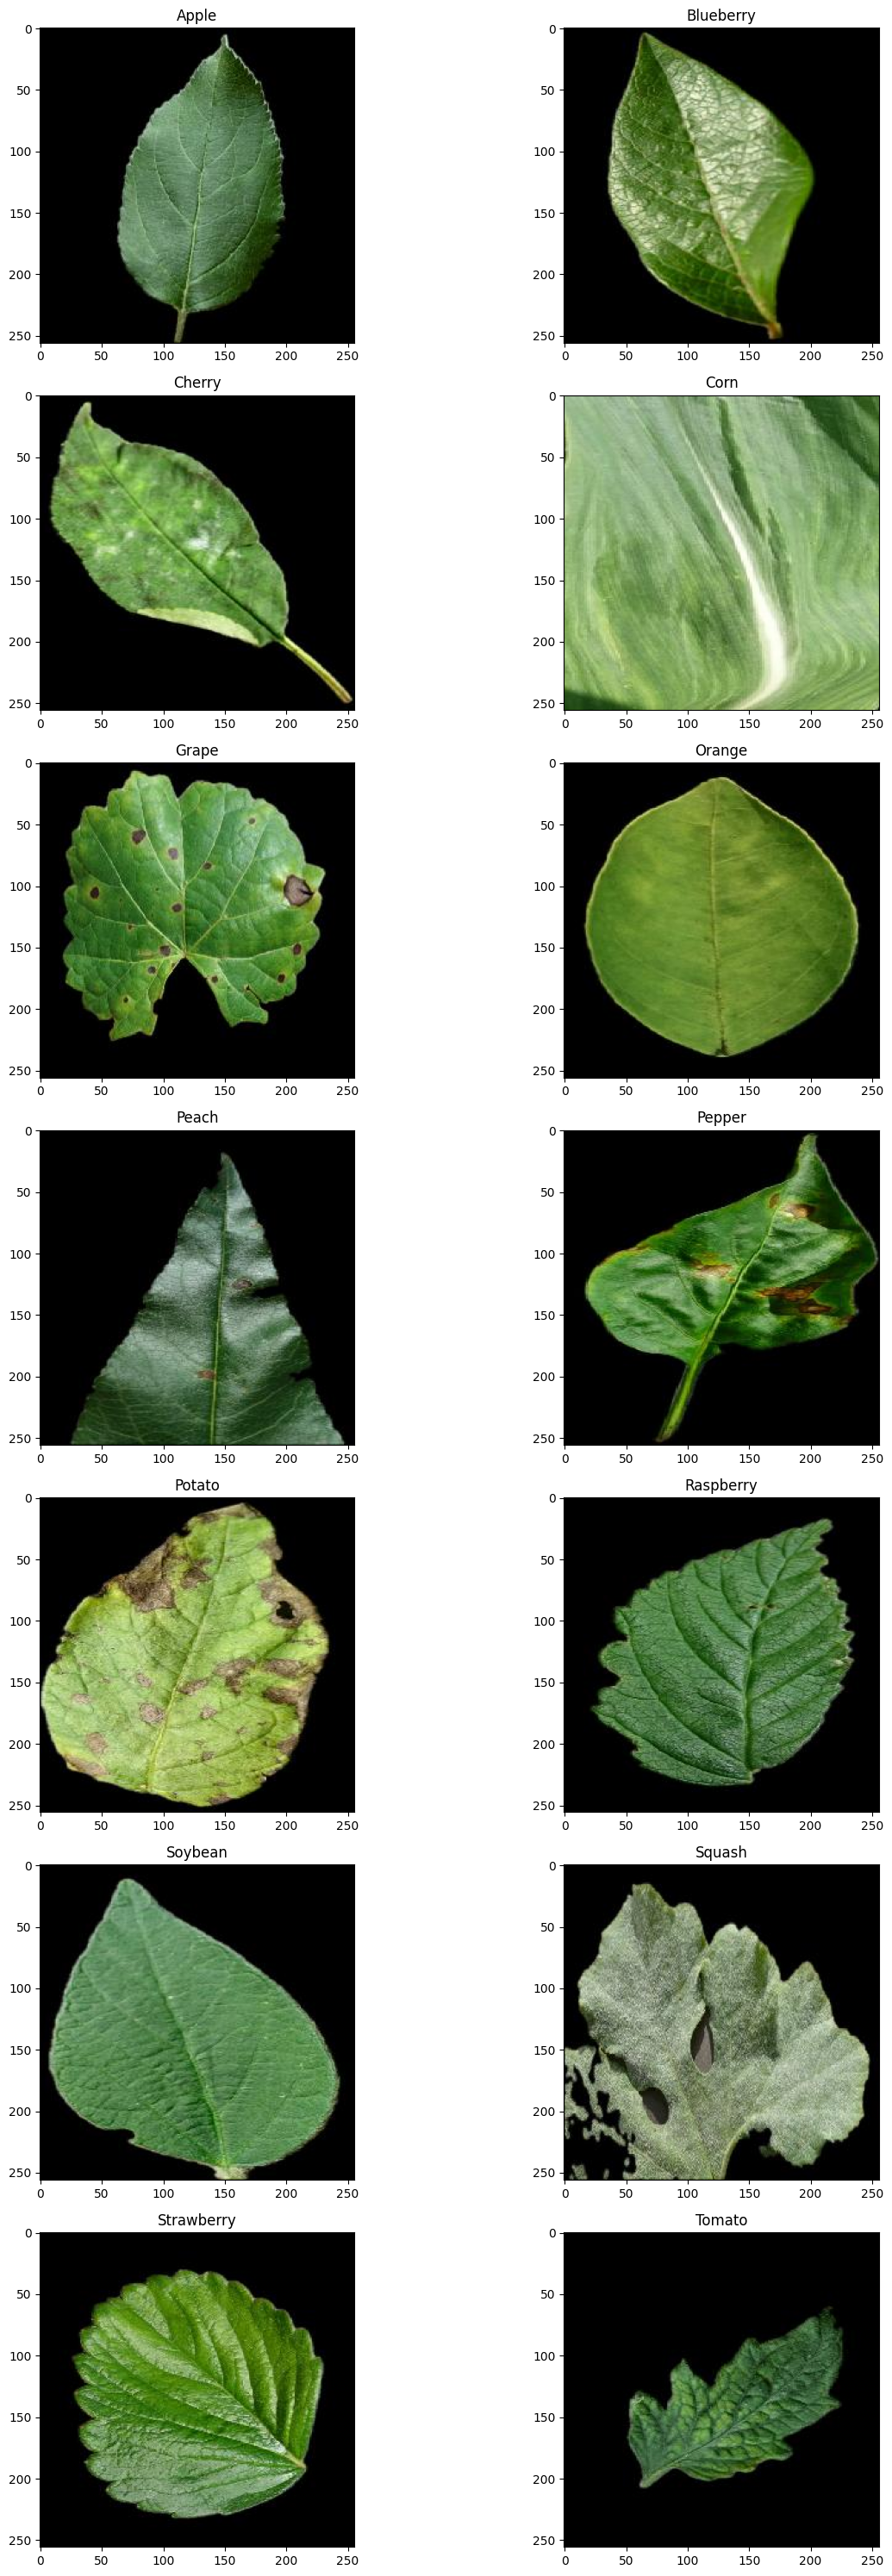

In [4]:
# Plot example images from the dataset (to check if the unzip procedure was successful)

labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

dataset_dir = "/kaggle/input/lead-classification-post-processed-dataset/archive/Post_Processed_Dataset/Training"

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [5]:
# Data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_data_gen_data_aug = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3, # To better recognize both veins (zoom in) and edges (zoom out) of the leaves
                                        horizontal_flip=True,
                                        vertical_flip=True, # To recognize leaves when they're upside down
                                        fill_mode='constant') # To avoid multiple leaves in the same image
                                        

valid_data_gen_data_aug = ImageDataGenerator()
test_data_gen_data_aug = ImageDataGenerator()

In [6]:
training_dir = '/kaggle/input/lead-classification-post-processed-dataset/archive/Post_Processed_Dataset/Training'
validation_dir = '/kaggle/input/lead-classification-post-processed-dataset/archive/Post_Processed_Dataset/Validation'
test_dir = '/kaggle/input/lead-classification-post-processed-dataset/archive/Post_Processed_Dataset/Test'

train_gen_data_aug = train_data_gen_data_aug.flow_from_directory(directory=training_dir,
                                                           target_size=(256,256),
                                                           color_mode='rgb',
                                                           classes=None, 
                                                           class_mode='categorical',
                                                           batch_size=64,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen_data_aug = valid_data_gen_data_aug.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False,
                                               seed=seed)

test_gen_data_aug = test_data_gen_data_aug.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False,
                                               seed=seed)

Found 14351 images belonging to 14 classes.
Found 1695 images belonging to 14 classes.
Found 1695 images belonging to 14 classes.


The training is divided into 2 steps

1.   First Step: 20 epochs in which all the layers of ResNet50 are setted to "trainable = False". In this way we are able to train a little bit the dense layers that we have put after ResNet50 before the fine tuning. In this phase we use a larger learning rate (1e-3)
2.   Second Step: 100 epochs in which the last layers of ResNet50 are setted to "trainable = True". In this way we fine tune ResNet50 togheter with our dense layers. In this phase we use a smaller learning rate (1e-4)

Splitting the training into 2 steps, we can fine tune the last layers of ResNet50 having our dense layers trained a little bit.

In [7]:
input_shape = (256, 256, 3)
epochs = 20

In [8]:
supernet = tfk.applications.ResNet50(
    include_top=False, # In a first moment, none of the layers of ResNet50 is trainable
    input_shape=(224,224,3),
    weights='imagenet')

supernet.trainable = False
supernet.summary()


94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [9]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('./working1')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

    # Model checkpoint
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only= True) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

    # Early Stopping
    es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

In [10]:
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))

x = tfkl.Resizing(224, 224, interpolation="bicubic")(inputs) # 224x224 is the input shape used by ResNet50
x = tfkl.GaussianNoise(stddev=0.1)(x) # We add some noise to generalize better
x = preprocess_input(x) # Preprocessing using the preprocessing function of ResNet50

x = supernet(x) # ResNet50

x = tfkl.MaxPooling2D( # Max pooling to reduce the number of parameters
    pool_size=(2, 2), strides=None, padding="valid", data_format=None)(x)

# Our dense layers

x = tfkl.Flatten(name='Flattening')(x) # Flattening 
x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    128, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    64, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, # 14 classes of leaves
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

model_aug_RN50_fine = tfk.Model(inputs=inputs, outputs=outputs, name='model_aug_RN50_fine')
model_aug_RN50_fine.summary()

Model: "model_aug_RN50_fine"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 gaussian_noise (GaussianNo  (None, 224, 224, 3)       0         
 ise)                                                            
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                               

In [11]:
# First step of the training
model_aug_RN50_fine.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

In [12]:
callbacks = create_folders_and_callbacks(model_name='model_aug_RN50_fine')

history = model_aug_RN50_fine.fit(
    x = train_gen_data_aug,
    batch_size = 64,
    epochs = epochs,
    validation_data = valid_gen_data_aug,
    callbacks = callbacks,
    class_weight = class_weights # Class weights computed by us
).history

Epoch 1/20
225/225 [==============================] - 259s 1s/step - loss: 2.0558 - accuracy: 0.3764 - val_loss: 0.7047 - val_accuracy: 0.8265
Epoch 2/20
225/225 [==============================] - 221s 982ms/step - loss: 1.1152 - accuracy: 0.6289 - val_loss: 0.4159 - val_accuracy: 0.8867
Epoch 3/20
225/225 [==============================] - 219s 971ms/step - loss: 0.9257 - accuracy: 0.7091 - val_loss: 0.2921 - val_accuracy: 0.9156
Epoch 4/20
225/225 [==============================] - 201s 895ms/step - loss: 0.8439 - accuracy: 0.7342 - val_loss: 0.3492 - val_accuracy: 0.9174
Epoch 5/20
225/225 [==============================] - 223s 990ms/step - loss: 0.7585 - accuracy: 0.7521 - val_loss: 0.2726 - val_accuracy: 0.9357
Epoch 6/20
225/225 [==============================] - 200s 889ms/step - loss: 0.6906 - accuracy: 0.7745 - val_loss: 0.2859 - val_accuracy: 0.9274
Epoch 7/20
225/225 [==============================] - 221s 983ms/step - loss: 0.6511 - accuracy: 0.7860 - val_loss: 0.2724 - va

In [13]:
model_aug_RN50_fine.get_layer('resnet50').trainable = True
for i, layer in enumerate(model_aug_RN50_fine.get_layer('resnet50').layers[:158]): # Fine Tuning
    layer.trainable=False
for i, layer in enumerate(model_aug_RN50_fine.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


model_aug_RN50_fine.summary()

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [14]:
# Second step of the training
model_aug_RN50_fine.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [15]:
callbacks = create_folders_and_callbacks(model_name='model_aug_RN50_fine')
epochs = 100

history = model_aug_RN50_fine.fit(
    x = train_gen_data_aug,
    batch_size = 64,
    epochs = epochs,
    validation_data = valid_gen_data_aug,
    callbacks = callbacks,
    class_weight = class_weights # Class weights computed by us
).history

Epoch 1/100
225/225 [==============================] - 224s 956ms/step - loss: 0.4263 - accuracy: 0.8599 - val_loss: 0.0955 - val_accuracy: 0.9764
Epoch 2/100
225/225 [==============================] - 208s 922ms/step - loss: 0.3683 - accuracy: 0.8712 - val_loss: 0.1010 - val_accuracy: 0.9758
Epoch 3/100
225/225 [==============================] - 228s 1s/step - loss: 0.3390 - accuracy: 0.8822 - val_loss: 0.0808 - val_accuracy: 0.9758
Epoch 4/100
225/225 [==============================] - 208s 923ms/step - loss: 0.3155 - accuracy: 0.8854 - val_loss: 0.0979 - val_accuracy: 0.9740
Epoch 5/100
225/225 [==============================] - 202s 896ms/step - loss: 0.3153 - accuracy: 0.8873 - val_loss: 0.0889 - val_accuracy: 0.9799
Epoch 6/100
225/225 [==============================] - 203s 900ms/step - loss: 0.2754 - accuracy: 0.9030 - val_loss: 0.1070 - val_accuracy: 0.9693
Epoch 7/100
225/225 [==============================] - 219s 975ms/step - loss: 0.2766 - accuracy: 0.9032 - val_loss: 0.07

In [16]:
model_aug_RN50_fine.save('./working2')

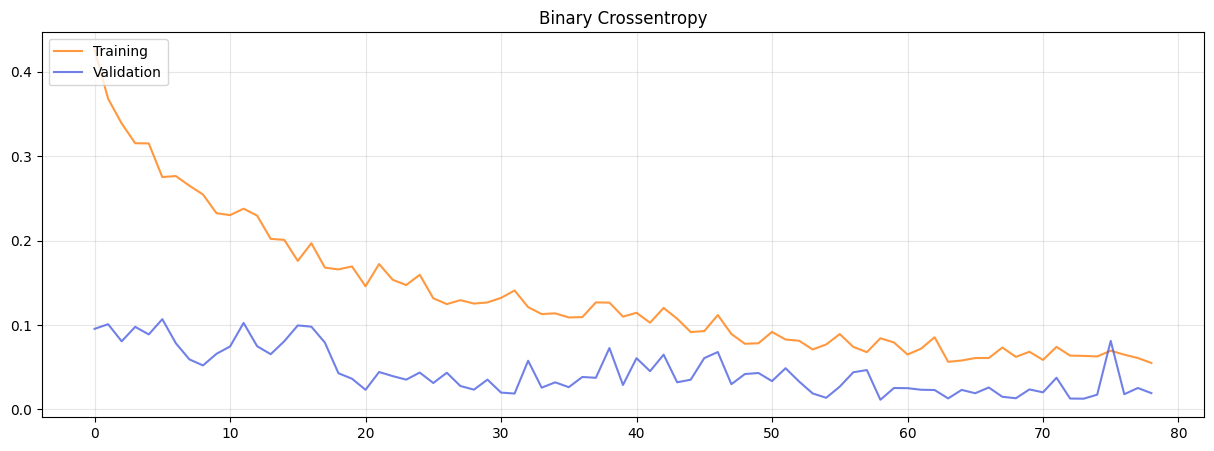

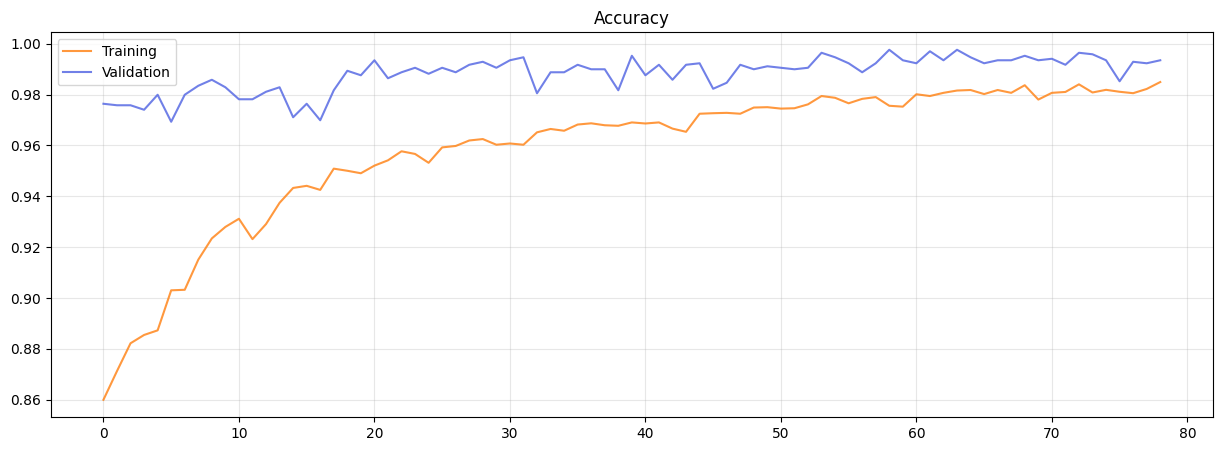

In [17]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

27/27 [==============================] - 6s 169ms/step
Confusion Matrix
[[ 94   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  45   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  56   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 115   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 138   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0 167   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  93   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  73   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  69   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  26   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 158   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  55   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  64   0]
 [  2   0   0   0   0   0   0   1   0   0   0   0   0 538]]
Accuracy: 0.9976
Precision: 0.9974
Recall: 0.9991
F1: 0.9982


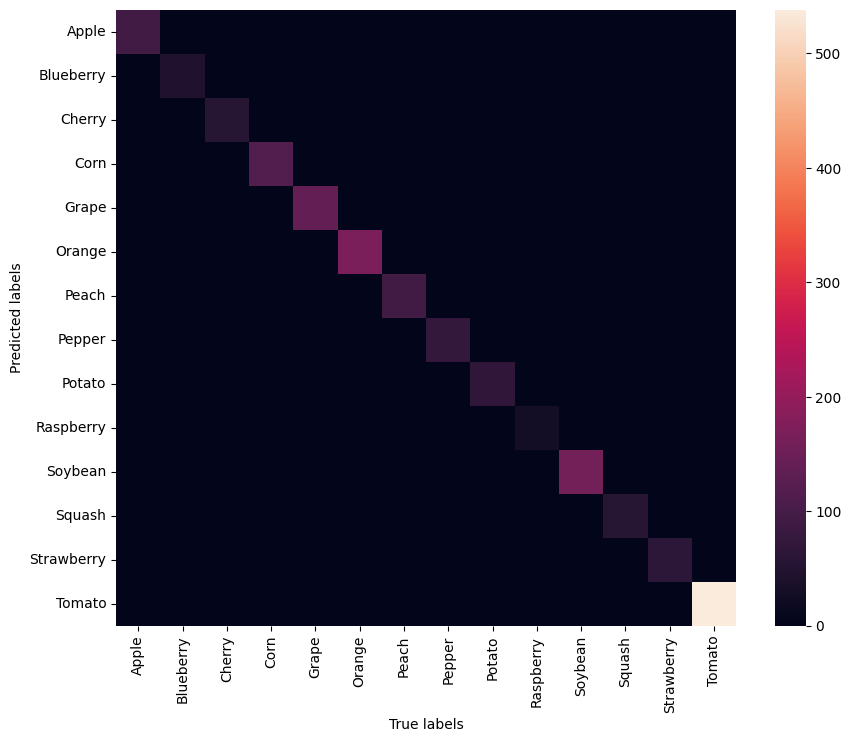

In [18]:
# Some information on the training

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Testing the model on the test set
predictions = model_aug_RN50_fine.predict(test_gen_data_aug)
y_pred = np.argmax(predictions, axis= -1)
y = test_gen_data_aug.classes

print('Confusion Matrix')
cm = confusion_matrix(y, y_pred)
print(cm)
labels = {0: 'Apple',1: 'Blueberry',2: 'Cherry',3: 'Corn',4: 'Grape',5: 'Orange',6: 'Peach',7: 'Pepper',8: 'Potato',9: 'Raspberry',10: 'Soybean',11: 'Squash',12: 'Strawberry',13: 'Tomato'}

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()